In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import plotly.express as px
plt.style.use(['science','ieee', 'no-latex']) # set the style of the plots

In [278]:
adult = pd.read_parquet('data/formatted_data.parquet')
train = adult[adult['set'] == 'train'].drop(columns=['set'])
test = adult[adult['set'] == 'test'].drop(columns=['set'])

In [265]:
train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# Data Preprocessing

In [274]:
from pandas.api.types import CategoricalDtype
def categoryLimit(col: pd.Series, count: int) -> pd.Series:
    """
    Limit the number of categories in a column to count.
    All others are 'other'.
    """
    if col.dtype.name != 'category' or col.name == 'target':
        return col
    # get the names of the top categories
    topCategories = col.value_counts().nlargest(count-1).index 
    # limit the categories to ontly the top categories
    col = col.astype(CategoricalDtype(categories=list(topCategories) + ['other'])) 
    # replace all categories not in the top categories with 'other'
    col.fillna('other', inplace=True)

    return col

def dfCategoryLimit(df: pd.DataFrame, count: int) -> pd.DataFrame:
    """
    Limit the number of categories in a dataframe to count.
    All others are 'other'.
    """
    return df.apply(lambda col: categoryLimit(col, count))

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

In [270]:
# build a column transformer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# split into catgeorical and everyhting else

# include a custom function to limit the number of categories in a column
def getPreprocessor():
    return ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include='category')),
            ('num', StandardScaler(), make_column_selector(dtype_exclude='category'))
        ],
    )

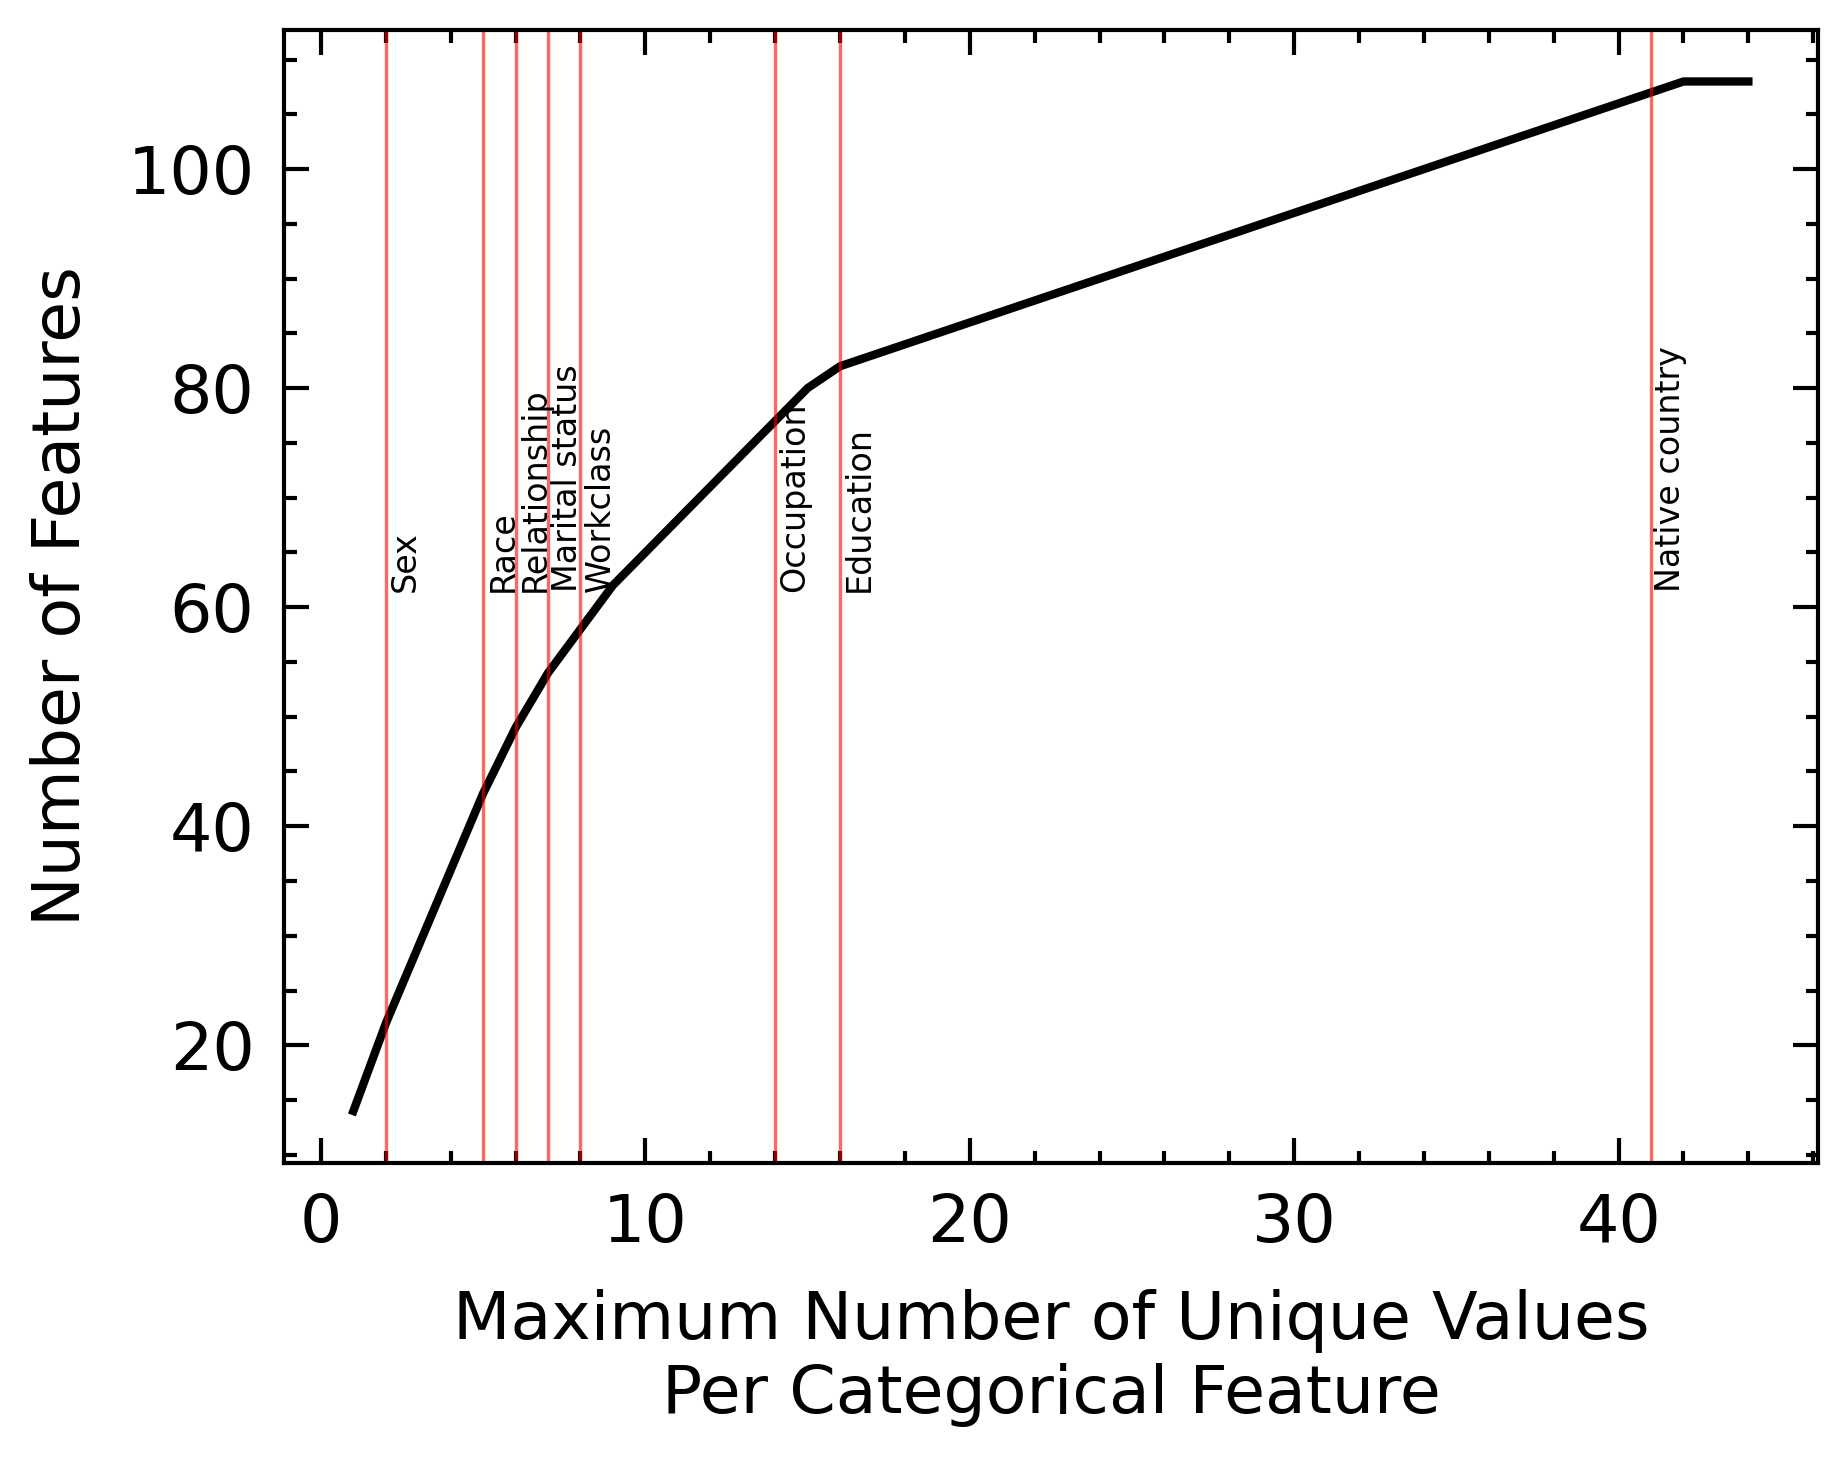

In [125]:
# get the num catgeories vs dimensionality
XTrain = train.drop(columns=['target'])

numCats = []
dims = []

for numCat in range(1, 45):
    XTrainCat = dfCategoryLimit(XTrain, numCat)
    data = getPreprocessor().fit_transform(XTrainCat)
    numCats.append(numCat)
    dims.append(data.shape[1])

# plot the number of categories vs dimensionality
fig, ax = plt.subplots()
ax.plot(numCats, dims)
ax.set_xlabel('Maximum Number of Unique Values\nPer Categorical Feature')
ax.set_ylabel('Number of Features')

for category, size in train.select_dtypes('category').nunique().items():
    if category == 'target':
        continue
    plt.axvline(x=size, color='r', linewidth=0.4, alpha=0.6)
    plt.text(size+0.1, 62, category.replace('-', ' ').capitalize(), rotation=90, fontsize=4)
plt.show()

# Fitting The Model

In [269]:
def XYSplit(train, test):
    XTrain = train.drop(columns=['target'])
    YTrain = train['target'].map({'<=50K': 0, '>50K': 1})

    XTest = test.drop(columns=['target'])
    YTest = test['target'].map({'<=50K': 0, '>50K': 1})

    return XTrain, YTrain, XTest, YTest

def donwSampleLabels(X, y):
    """
    Downsample the labels to make the data more balanced.
    """
    # get the number of samples in each class
    numSamples = y.value_counts()
    # get the minimum number of samples
    minSamples = numSamples.min()
    # get the index of the samples to keep
    keepIdx = y.groupby(y).apply(lambda x: x.sample(minSamples, random_state=0, replace=False)).index.get_level_values(1)
    # get the downsampled data
    X = X.loc[keepIdx]
    y = y.loc[keepIdx]

    return X, y

In [286]:
def runLogisticRegression(XTrainTrans, YTrain, n_iter, max_iter):    
    clf = RandomizedSearchCV(
        estimator=LogisticRegression(max_iter=max_iter, solver='saga'),
        param_distributions={
            'C': np.logspace(-4, 4, 9),
            'penalty':  ['elasticnet', 'l1', 'l2', 'none'],
            'l1_ratio': np.linspace(0, 1, 11), # for elasticnet
        },
        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        refit='roc_auc',
        n_iter=n_iter,
        cv=4,
        n_jobs=-1
        )
    return clf.fit(XTrainTrans, YTrain)

In [284]:
def getMetrics(clf, XTest, YTest):
    """
    Get the metrics for the test data.
    """
    YPred = clf.predict(XTest)
    YPredProb = clf.predict_proba(XTest)[:, 1]

    metrics = {
        'accuracy': accuracy_score(YTest, YPred),
        'precision': precision_score(YTest, YPred),
        'recall': recall_score(YTest, YPred),
        'f1': f1_score(YTest, YPred),
        'roc_auc': roc_auc_score(YTest, YPredProb)
    }
    return metrics

In [287]:
# train, test
MAX_CAT = 10


train_ = dfCategoryLimit(train, MAX_CAT)
XTrain, YTrain, XTest, YTest = XYSplit(train_, test)
XTrain, YTrain = donwSampleLabels(XTrain, YTrain)

preprocessor = getPreprocessor().fit(XTrain)
XTrainTrans = preprocessor.transform(XTrain)
XTestTrans = preprocessor.transform(XTest)

search = runLogisticRegression(XTrainTrans, YTrain, n_iter=10, max_iter=1000)
testMetrics = getMetrics(search, XTestTrans, YTest)
cvResults = search.cv_results_


c:\Users\brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [293]:
getMetrics(search, XTestTrans, YTest)

{'accuracy': 0.8042503531724096,
 'precision': 0.5565665236051502,
 'recall': 0.842953718148726,
 'f1': 0.6704580705201117,
 'roc_auc': 0.9035983369370963}

In [294]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,param_l1_ratio,param_C,params,split0_test_accuracy,split1_test_accuracy,...,mean_test_f1,std_test_f1,rank_test_f1,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,22.545206,0.169755,0.027557,0.007925,elasticnet,0.5,10000.0,"{'penalty': 'elasticnet', 'l1_ratio': 0.5, 'C'...",0.810763,0.839582,...,0.827135,0.0106,1,0.895585,0.918495,0.904307,0.901968,0.905089,0.008372,1


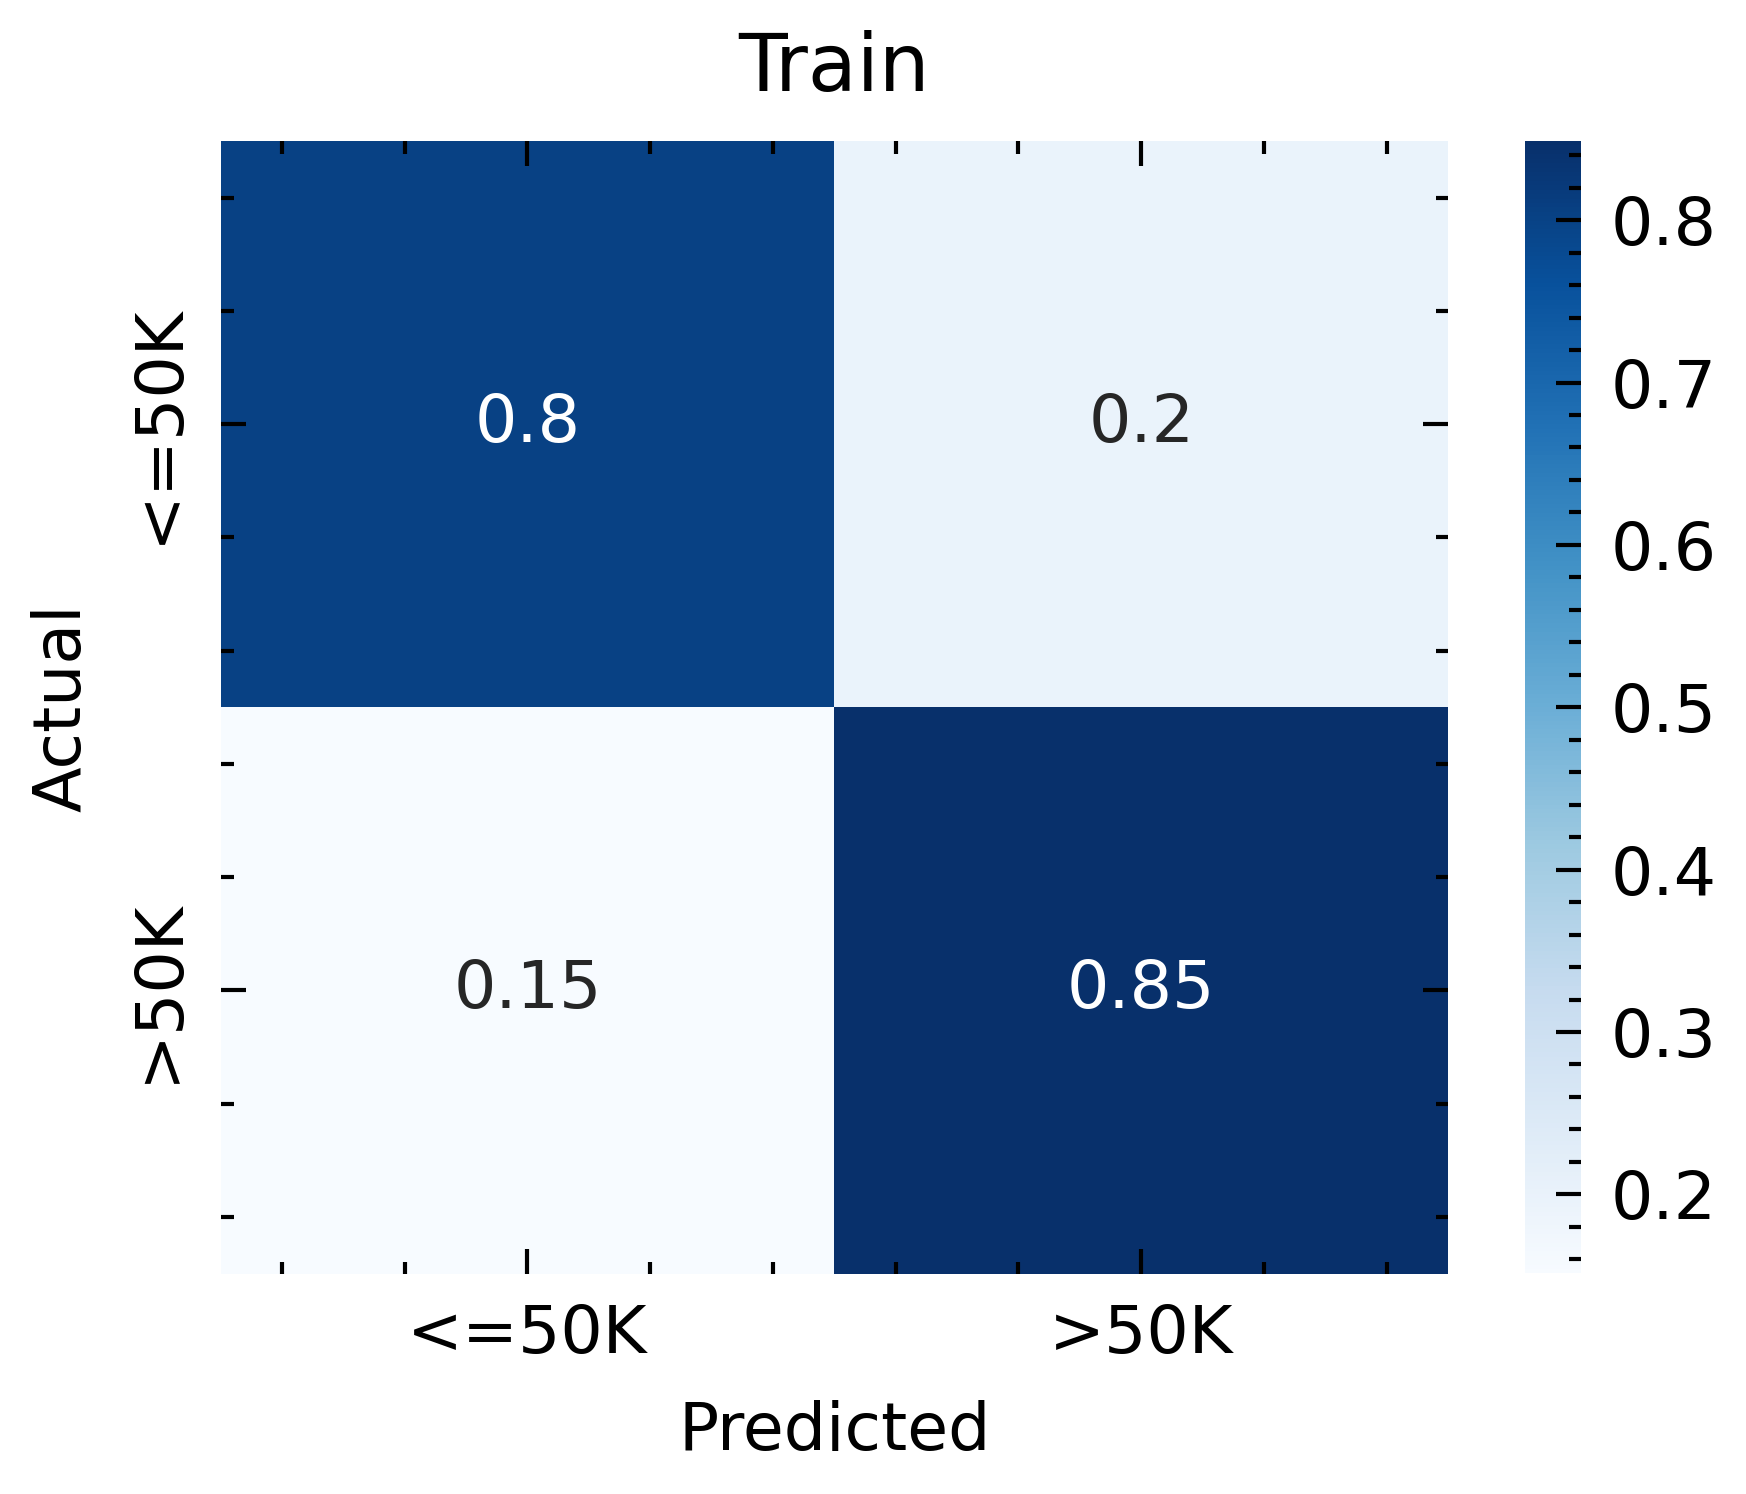

In [266]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plotConfusionMatrix(yTrue, yPred, labels, title, savePath=None):
    cm = confusion_matrix(yTrue, yPred, normalize='true')
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)
    plt.show()
    if savePath is not None:
        fig.savefig(savePath, bbox_inches='tight')

YTrainPred = search.predict(XTrainTrans)
YTestPred = search.predict(XTestTrans)

plotConfusionMatrix(YTrain, YTrainPred, ['<=50K', '>50K'], 'Train')

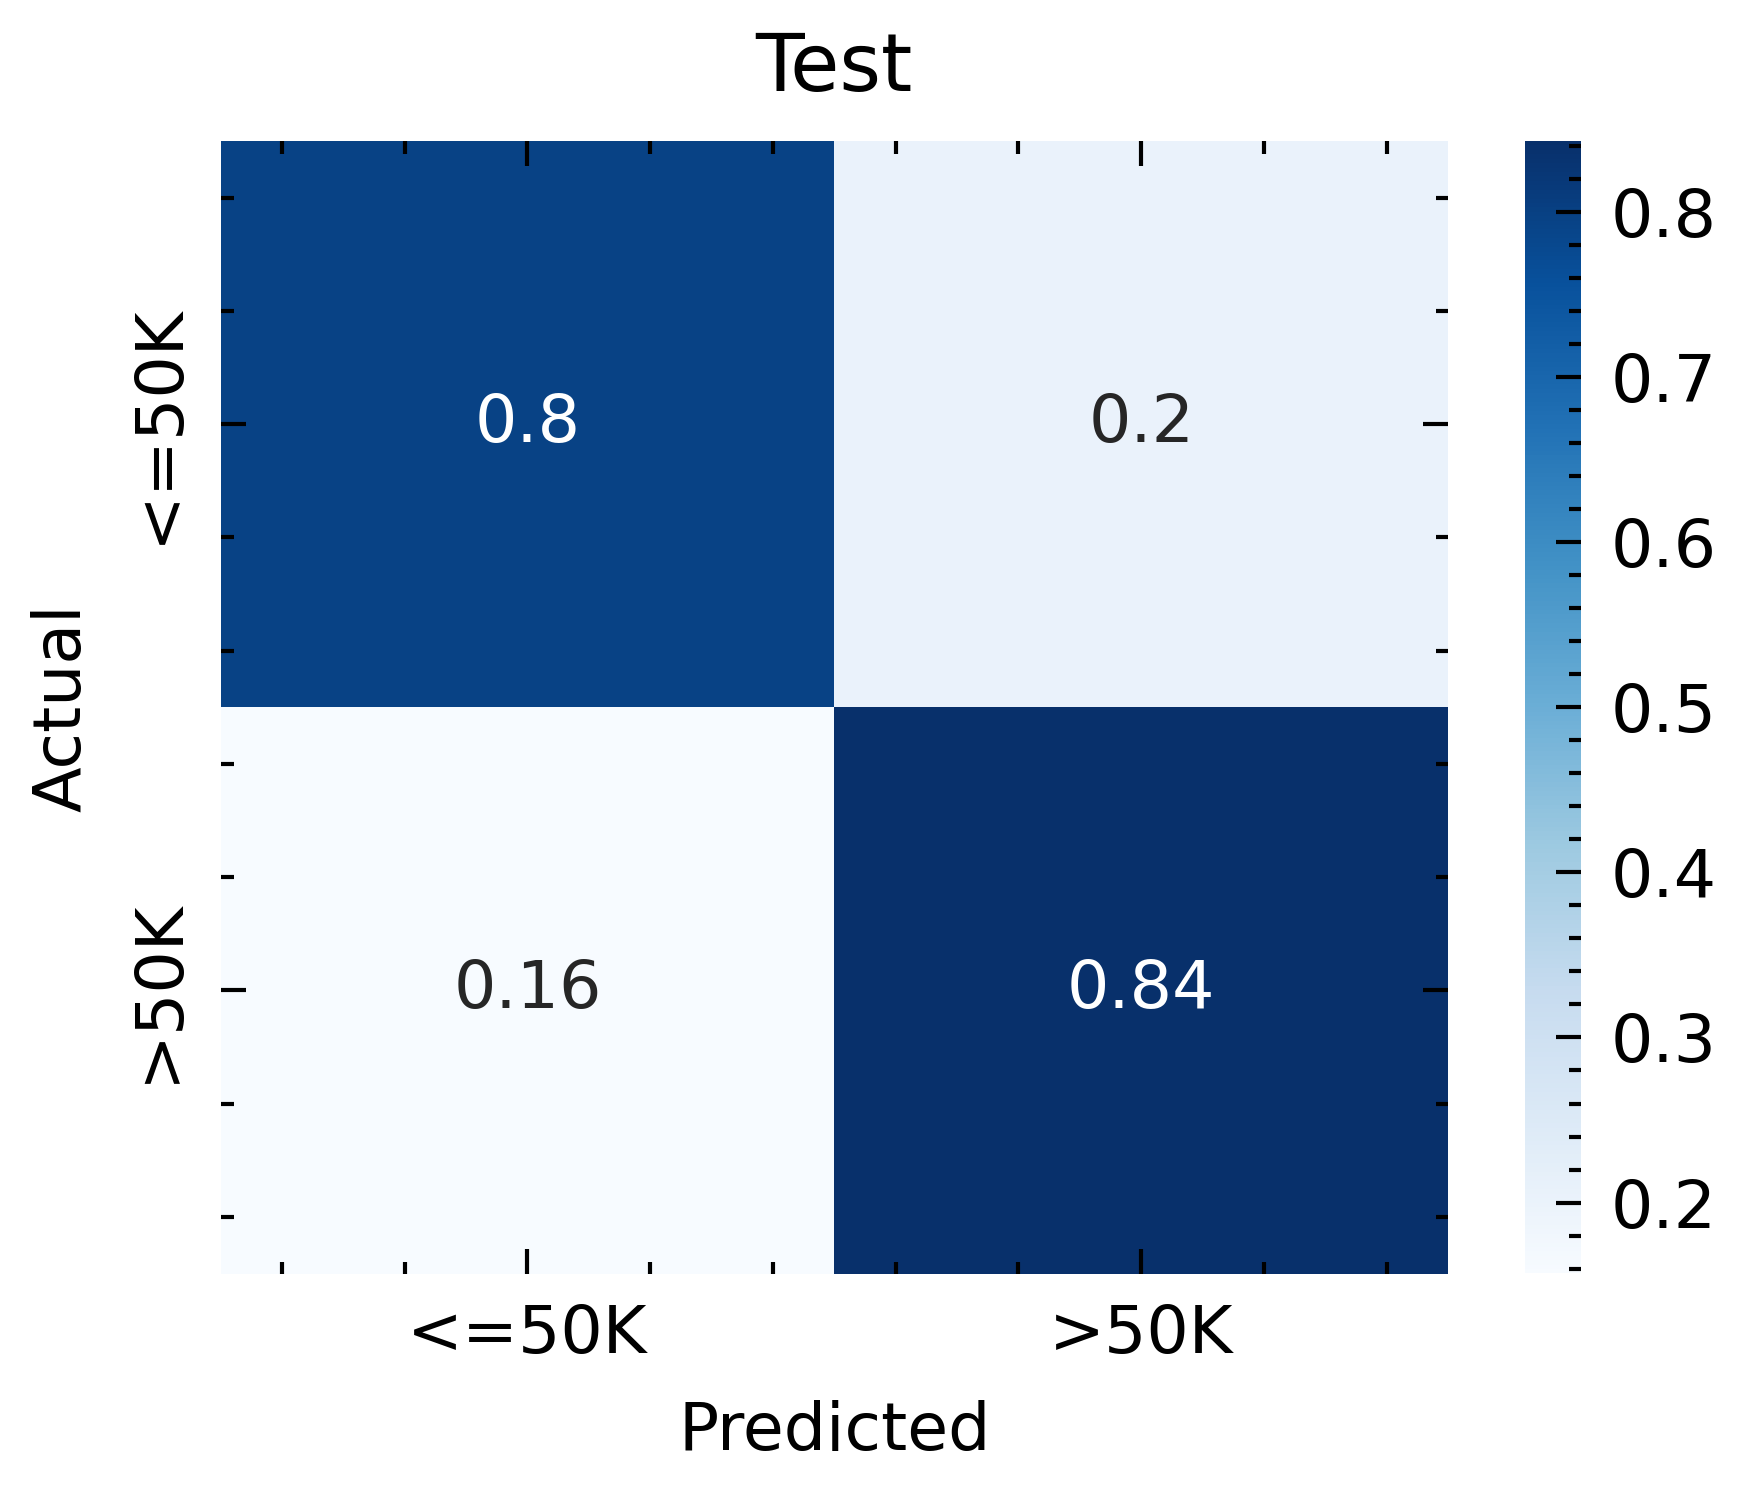

In [263]:
plotConfusionMatrix(YTest, YTestPred, ['<=50K', '>50K'], 'Test')

# Active Learning

In [ ]:
XTrain = train.drop(columns=['target'])
YTrain = train['target'].map({'<=50K': 0, '>50K': 1})

XTest = test.drop(columns=['target'])
YTest = test['target'].map({'<=50K': 0, '>50K': 1})